In [1]:
import numpy as np
import scanpy as sc


In [36]:
import os

files = os.listdir("processed_files/significant_subpopulation")

In [85]:
data_names = []
data_pseudobulk_expression = []
disease = []

for f in files:
    cluster_k = sc.read(f"processed_files/significant_subpopulation/{f}")
    cluster_k = cluster_k[:, cluster_k.var[cluster_k.var["highly_variable"] == True].index]
    pseudobulk = cluster_k.X.mean(axis=0)
    name = f.replace("cluster", "").replace(".h5ad", "")
    condition = cluster_k.obs["disease"].value_counts().idxmax()

    data_names.append(name)
    data_pseudobulk_expression.append(pseudobulk)
    disease.append(condition)

In [86]:
import pandas as pd
import numpy as np

mean_expression_df = pd.DataFrame(np.squeeze(data_pseudobulk_expression), columns=cluster_k.var["feature_name"])
mean_expression_df.index = data_names

name_condition = pd.DataFrame({"name":data_names, "condition": disease})

In [87]:
alzheimers_clusters = name_condition[name_condition["condition"] != "normal"]
normal_clusters = name_condition[name_condition["condition"] == "normal"]

In [88]:
normal_clusters_expression = mean_expression_df.loc[normal_clusters["name"]]
alzheimers_clusters_expression = mean_expression_df.loc[alzheimers_clusters["name"]]

In [89]:
df_combined = pd.concat([normal_clusters_expression, alzheimers_clusters_expression])

In [90]:
corr_matrix = df_combined.T.corr(method='pearson')

In [92]:
corr_matrix.shape

(131, 131)

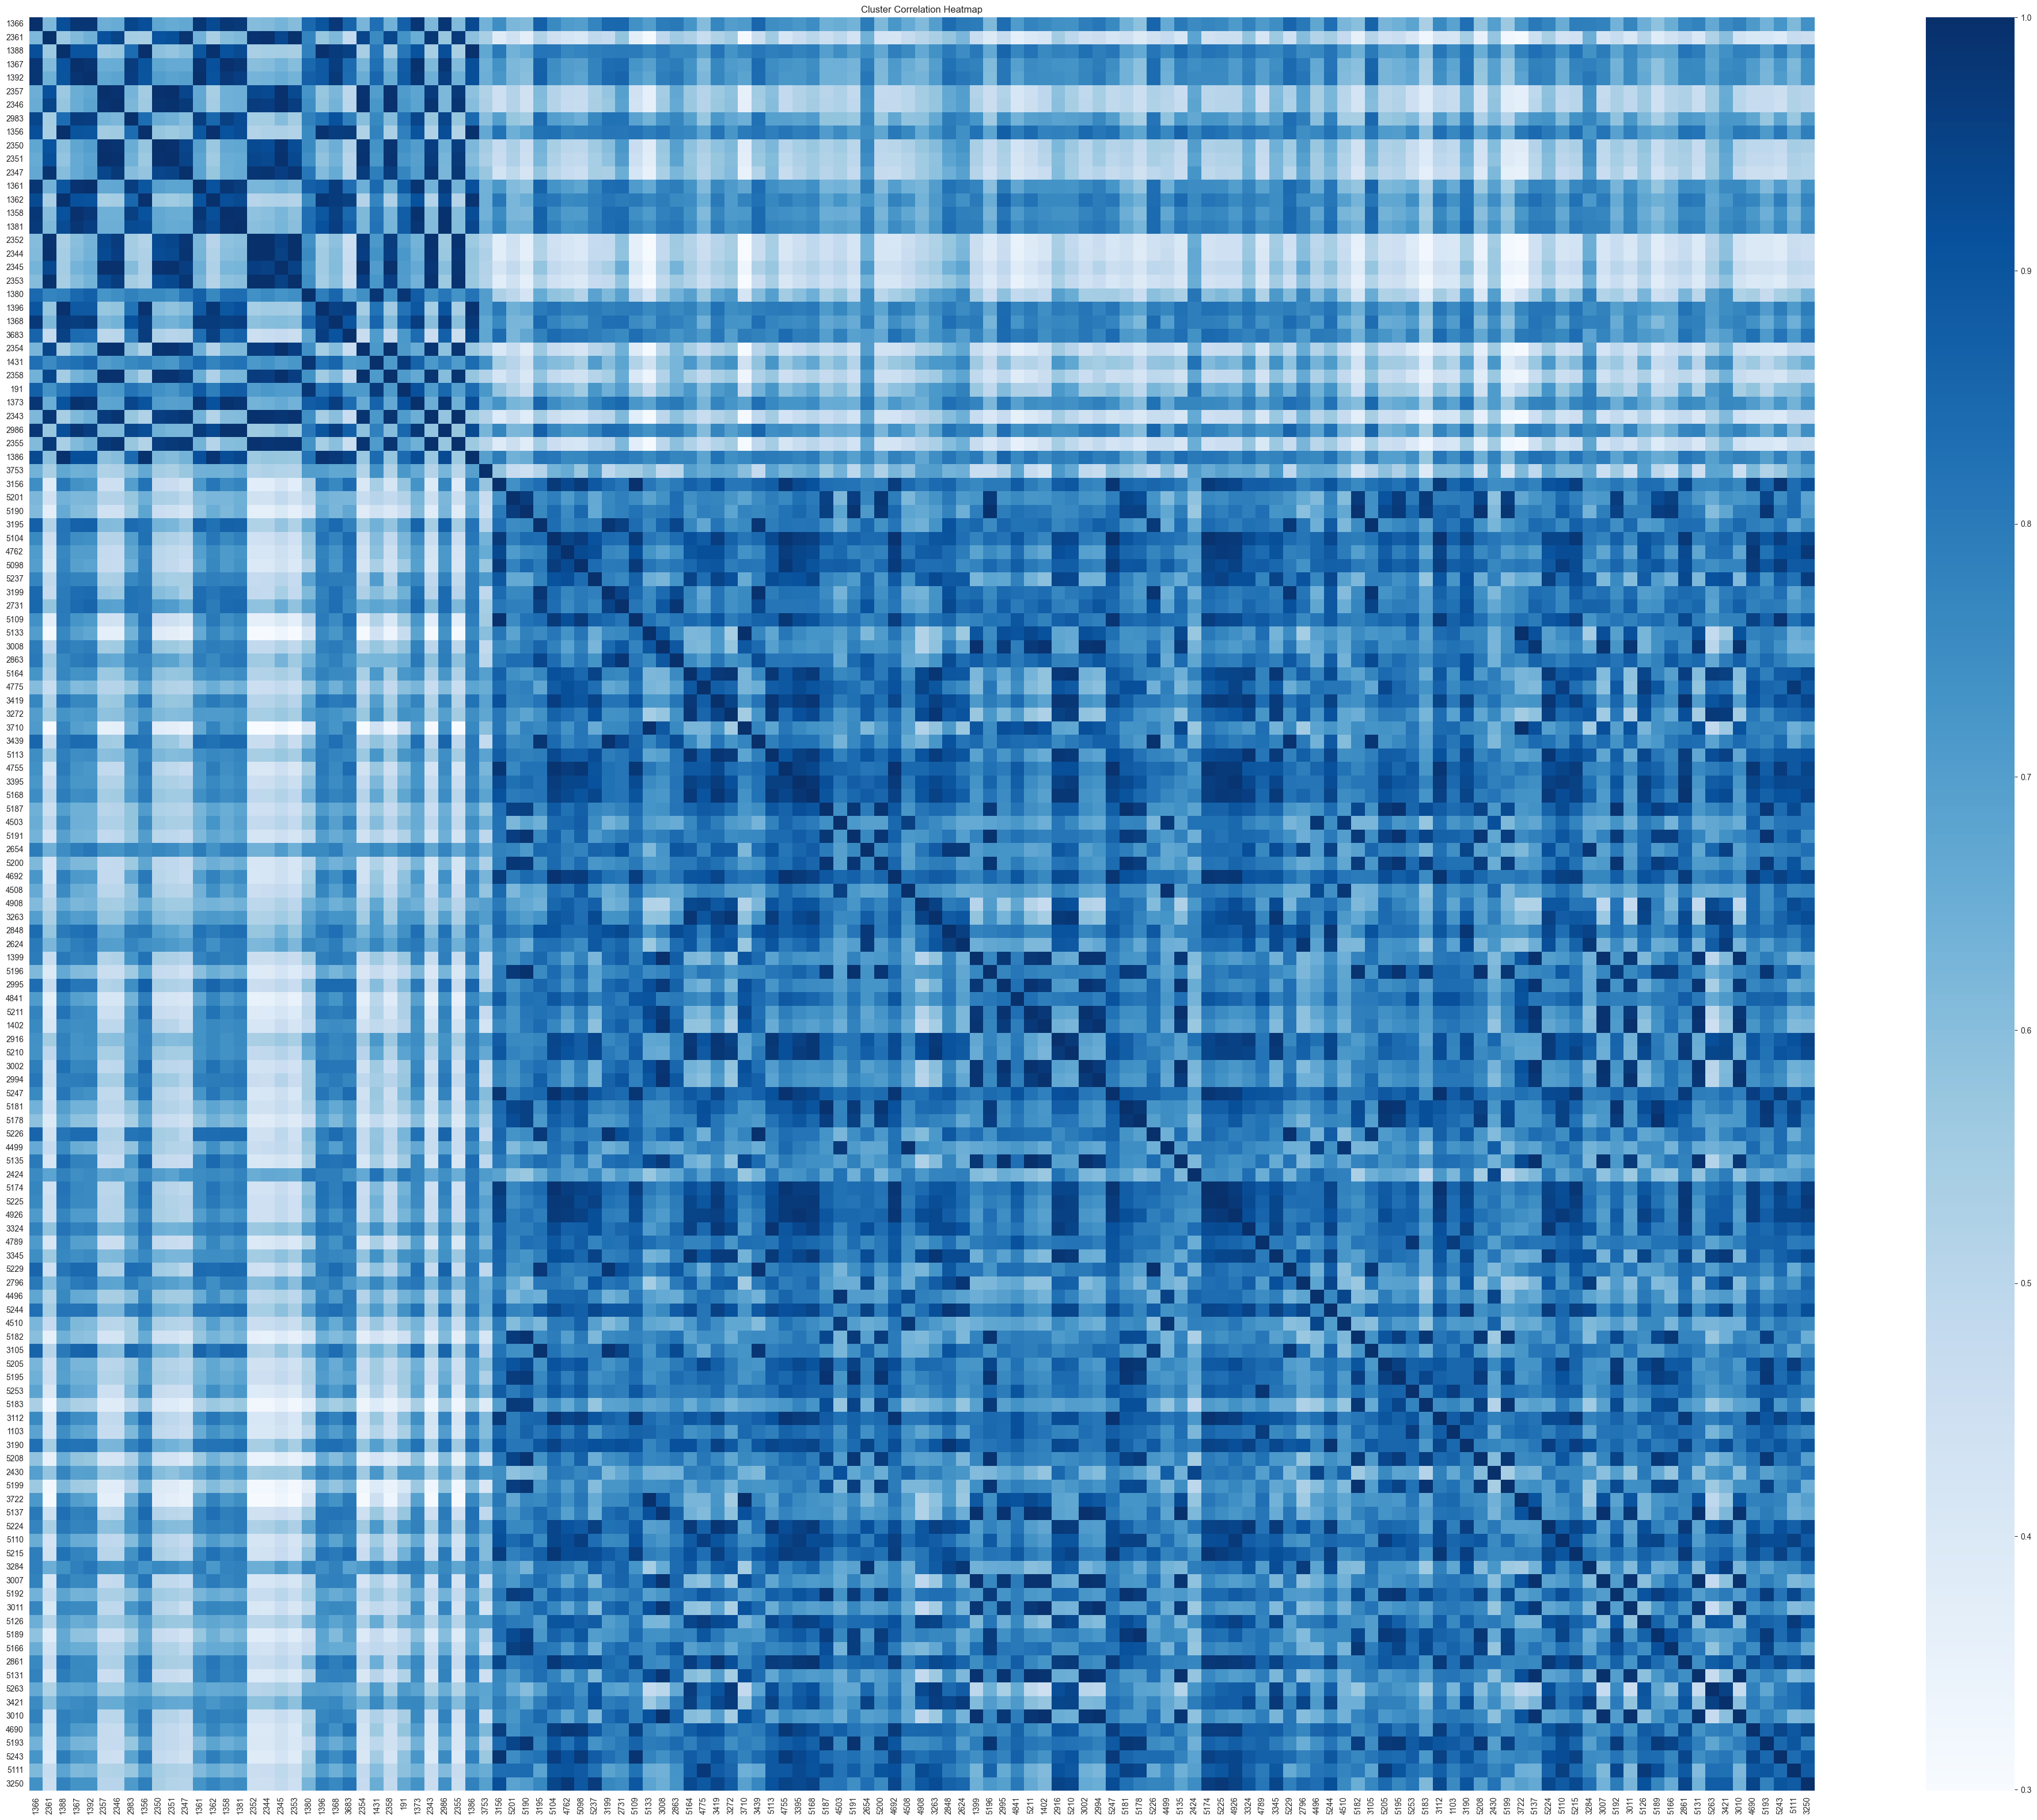

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(50, 40))
sns.heatmap(corr_matrix, cmap="Blues")
plt.title("Cluster Correlation Heatmap")
plt.savefig("correlation_heatmap.png")
plt.show()

In [73]:
alzheimers_cor = corr_matrix.iloc[normal_clusters.shape[0]:]
normal_cor = corr_matrix.iloc[:normal_clusters.shape[0]]

In [106]:
alzheimers_alzheimers_corr = alzheimers_cor.T.iloc[normal_clusters.shape[0]:].mean()
alzheimers_normal_corr = alzheimers_cor.T.iloc[:normal_clusters.shape[0]].mean()

In [124]:
alzheimers_normal_corr.T.loc["2424"], alzheimers_alzheimers_corr.T.loc["2424"]

(np.float64(0.7274446965912114), np.float64(0.6929536003861775))

In [119]:
alzheimers_cor[alzheimers_normal_corr > alzheimers_alzheimers_corr]

,1366,2361,1388,1367,1392,2357,2346,2983,1356,2350,...,2861,5131,5263,3421,3010,4690,5193,5243,5111,3250
2424,0.756244,0.683454,0.782542,0.744745,0.754799,0.669544,0.681907,0.667973,0.77097,0.704097,...,0.7681,0.578771,0.724828,0.794214,0.587148,0.692814,0.640901,0.683621,0.693285,0.750003


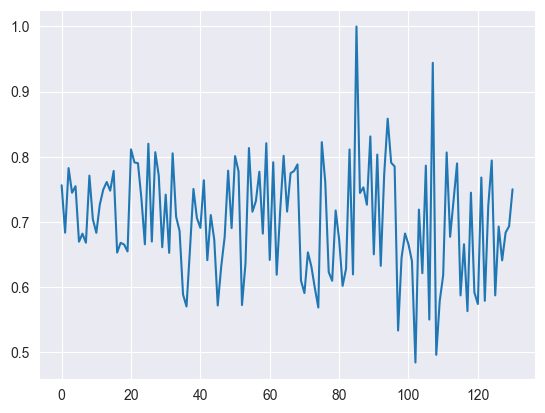

In [114]:
plt.plot(np.arange(131), alzheimers_cor[alzheimers_normal_corr > alzheimers_alzheimers_corr].iloc[0])

In [116]:
## inspect the potential resilient cluster
selected_cluster = sc.read("processed_files/significant_subpopulation/cluster2424.h5ad")

In [117]:
selected_cluster.obs["donor_id"].value_counts()

donor_id
146    271
44      72
32       7
35       1
91       1
103      1
145      1
Name: count, dtype: int64

In [152]:
clustered_dataframe = sc.AnnData(df_combined)
clusted_dataframe.write("data/clustered_dataframe.h5ad")
clustered_dataframe.var_names = list(df_combined.columns)

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [153]:
test = sc.read("data/clustered_dataframe.h5ad")

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


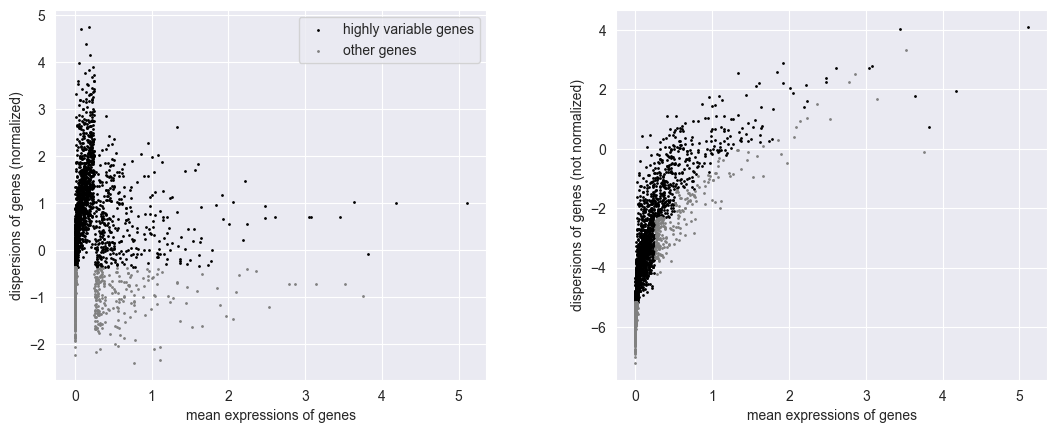

In [162]:
sc.pp.highly_variable_genes(test, n_top_genes=2000)
sc.pl.highly_variable_genes(test)

In [172]:
test.obs["pseudobulk"] = test.obs.index.astype('category')

In [173]:
test

AnnData object with n_obs × n_vars = 114 × 5000
    obs: 'pseudobulk'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'rank_genes_groups'

In [181]:
test.obs

,pseudobulk
1940,1940
1960,1960
2,2
4348,4348
1961,1961
...,...
4852,4852
6592,6592
1386,1386
4653,4653


In [3]:
df_combined.index

NameError: name 'df_combined' is not defined

In [ ]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

# Enable automatic conversion between pandas and R

# Pass your data to R
with pandas2ri.converter.context():

    ro.globalenv['counts'] = pandas2ri.py2rpy(df_combined.T)  # genes x samples
    ro.globalenv['metadata'] = pandas2ri.py2rpy(test.obs)


ro.r('''
library(edgeR)

# Create DGEList and normalize
dge <- DGEList(counts=counts)
dge <- calcNormFactors(dge)

# Design matrix
design <- model.matrix(~0 + factor(metadata$pseudobulk))
colnames(design) <- make.names(levels(factor(metadata$pseudobulk)))

# Fixed dispersion for single-sample pseudobulk
dge$common.dispersion <- 0.1
fit <- glmFit(dge, design)

# Prepare one-vs-rest DE for each group
groups <- colnames(design)
de_results <- list()

for (g in groups) {
    rest <- setdiff(groups, g)
    contrast_str <- paste0(g, " - (", paste(rest, collapse = " + "), ")/", length(rest))
    contrast <- makeContrasts(contrasts = contrast_str, levels=design)

    res <- glmLRT(fit, contrast=contrast)
    de_results[[g]] <- topTags(res, n=Inf)$table  # return all DE genes
}
''')

# Convert each group's DE results to pandas DataFrames
group_names = ro.r('names(de_results)')
de_results_dict = {}
for g in group_names:
    df = pandas2ri.rpy2py_dataframe(ro.r(f'de_results[["{g}"]]'))
    de_results_dict[g] = df

# Example: access DE results for group "X1386"
example_df = de_results_dict["X1386"]
print(example_df.head())

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '
Exception ignored from cffi callback <function _callback_wrapper_ABI.<locals>.outer_func at 0x135723b00>:
Traceback (most recent call last):
  File "/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/rpy2/rinterface_lib/ffi_proxy.py", line 62, in outer_func
    def outer_func(*args, **kwargs):
KeyboardInterrupt: 


In [2]:
print(x[0])

NameError: name 'x' is not defined